# American Express - Default Prediction
> Calculated by observing 18 months performance window after the latest credit card statement, <br>
and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

It is based on the <a href="https://www.kaggle.com/code/ambrosm/amex-eda-which-makes-sense" target="_blank">EDA which makes sense ⭐️⭐️⭐️⭐️⭐️</a>.

## 1. Check Data

D_* : Delinquency variables<br>
S_* : Spend variables <br>
P_* : Payment variables <br>
B_* : Balance variables <br>
R_* : Risk variables <br>

### Labels
For trainnig data, We can know there aren't duplicated customer_ID. <br>
Because of imbalancing classes, It needs cross-validation.

In [13]:
import pandas as pd
import numpy as np
import pickle, gc
from matplotlib import pyplot as plt

In [7]:
train_labels = pd.read_csv('./train_labels.csv')
train_labels.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [8]:
# check null data
train_labels.isnull().sum()

customer_ID    0
target         0
dtype: int64

In [9]:
label_stats = pd.DataFrame({'absolute': train_labels.target.value_counts(),
              'relative': train_labels.target.value_counts() / len(train_labels)})
label_stats['absolute upsampled'] =  label_stats.absolute * np.array([20, 1])
label_stats['relative upsampled'] = label_stats['absolute upsampled'] / label_stats['absolute upsampled'].sum()
label_stats

,absolute,relative,absolute upsampled,relative upsampled
0,340085,0.741066,6801700,0.98283
1,118828,0.258934,118828,0.01717


In [22]:
# import data
train = pd.read_feather('./train_data.ftr')
test = pd.read_feather('./test_data.ftr')
with pd.option_context("display.min_rows", 6):
    display(train)
    display(test)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.982910,0.444092,0.013153,0.815430,0.003456,0.100525,0.002111,0.012344,...,NaN,NaN,0.009956,0.009995,0.001088,NaN,0.005692,0.006775,0.005566,0
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969727,0.442627,0.009857,1.003906,0.005116,0.101807,0.009933,0.008575,...,NaN,NaN,0.005543,0.006565,0.009880,NaN,0.008125,0.001168,0.003983,0
5531450,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-03-14,0.981934,0.002474,0.000077,0.992676,0.000809,0.119141,0.003286,0.014091,...,NaN,NaN,0.007317,0.002888,0.006207,NaN,0.005112,0.003183,0.001914,0


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631348,0.001912,0.010727,0.814453,0.007545,0.168701,0.009972,0.002348,...,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008278,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.586914,0.005276,0.011024,0.811035,0.001817,0.241333,0.000166,0.009132,...,NaN,NaN,NaN,0.000142,0.004940,0.009018,NaN,0.003695,0.003754,0.001460
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.608887,0.003326,0.016388,1.004883,0.000114,0.267090,0.004196,0.004192,...,NaN,NaN,NaN,0.000074,0.002113,0.004658,NaN,0.003155,0.002155,0.006481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11363759,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-02-17,0.459961,0.005245,0.004421,0.818848,0.000665,NaN,0.000559,0.007057,...,NaN,NaN,NaN,0.007797,0.007740,0.008194,NaN,0.009384,0.003593,0.005604
11363760,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-03-19,0.460449,0.002663,0.009529,0.816406,0.009026,NaN,0.008530,0.006851,...,NaN,NaN,NaN,0.007195,0.008453,0.004776,NaN,0.006199,0.005604,0.005970
11363761,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2019-04-18,0.454590,0.004402,0.000346,0.810059,0.008736,NaN,0.000937,0.003494,...,NaN,NaN,NaN,0.003399,0.009590,0.006187,NaN,0.007675,0.006443,0.003143


In [27]:
train.info(max_cols=200, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 191 columns):
 #    Column       Non-Null Count    Dtype         
---   ------       --------------    -----         
 0    customer_ID  5531451 non-null  object        
 1    S_2          5531451 non-null  datetime64[ns]
 2    P_2          5485466 non-null  float16       
 3    D_39         5531451 non-null  float16       
 4    B_1          5531451 non-null  float16       
 5    B_2          5529435 non-null  float16       
 6    R_1          5531451 non-null  float16       
 7    S_3          4510907 non-null  float16       
 8    D_41         5529435 non-null  float16       
 9    B_3          5529435 non-null  float16       
 10   D_42         791314 non-null   float16       
 11   D_43         3873055 non-null  float16       
 12   D_44         5257132 non-null  float16       
 13   B_4          5531451 non-null  float16       
 14   D_45         5529434 non-null  float16       
 1

> There are many columns and many missing data -> Don't have to drop columns which have null data. <br>
There are many 16-bit float features -> Don't have to round up.

Text(0.5, 1.0, 'Test statements per customer')

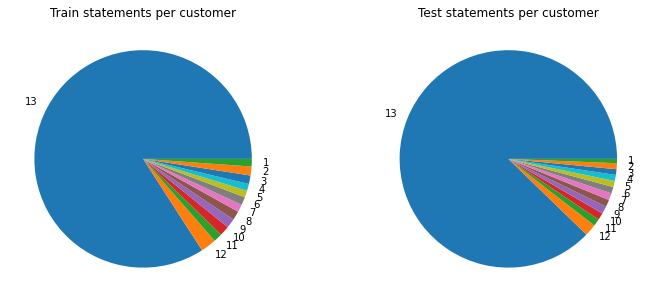

In [32]:
# Check the statements per customer
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
train_sc = train.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Train statements per customer')
ax1.pie(train_sc, labels=train_sc.index)
ax1.set_title(train_sc.name)

test_sc = test.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Test statements per customer')
ax2.pie(test_sc, labels=train_sc.index)
ax2.set_title(test_sc.name)

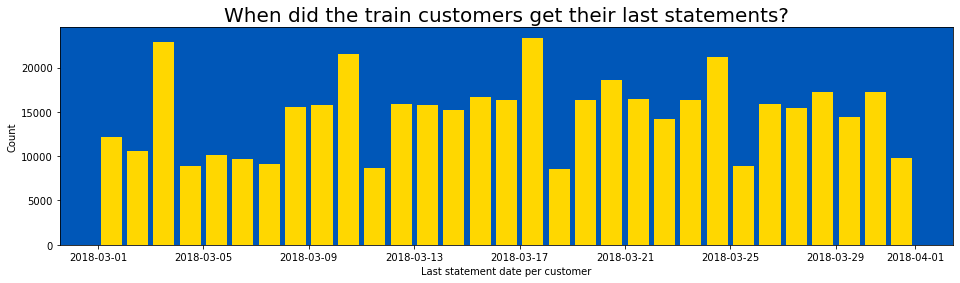

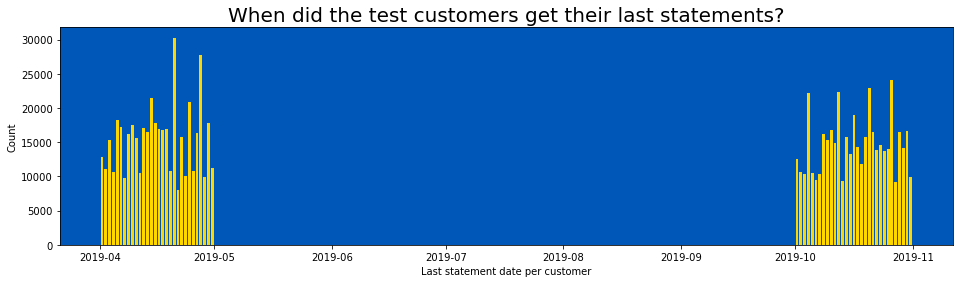

In [42]:
# Find customers last stement
temp = train['S_2'].groupby(train.customer_ID).max()
plt.figure(figsize=(16, 4))
plt.hist(temp, bins=pd.date_range("2018-03-01", "2018-04-01", freq="d"), rwidth=0.8, color='#ffd700')
plt.title('When did the train customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp

temp = test['S_2'].groupby(test.customer_ID).max()
plt.figure(figsize=(16, 4))
plt.hist(temp, bins=pd.date_range("2019-04-01", "2019-11-01", freq="d"), rwidth=0.74, color='#ffd700')
plt.title('When did the test customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp

> Train data placed between "2018-03-01" and "2018-04-01", <br>
Test data placed between "2019-04-01"and "2019-11-01"

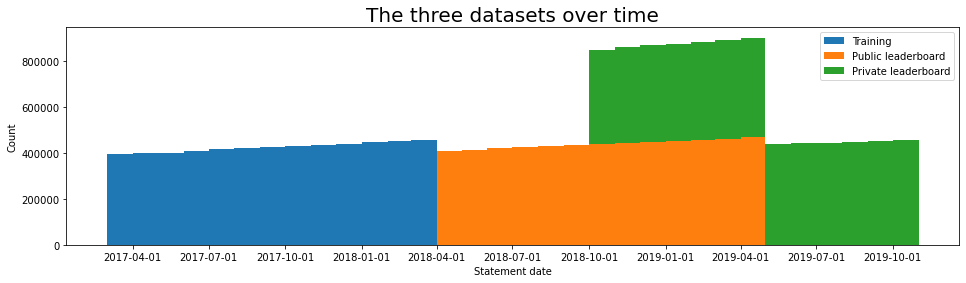

In [43]:
temp =  pd.concat([train[['customer_ID', 'S_2']], test[['customer_ID', 'S_2']]], axis=0)
temp.set_index('customer_ID', inplace=True)
temp['last_month'] = temp.groupby('customer_ID')['S_2'].max().dt.month
last_month = temp['last_month'].values

plt.figure(figsize=(16, 4))
plt.hist([temp.S_2[temp.last_month == 3],
          temp.S_2[temp.last_month == 4],
          temp.S_2[temp.last_month == 10]],
         bins=pd.date_range("2017-03-01", "2019-11-01", freq="MS"),
         label=['Training', 'Public leaderboard', 'Private leaderboard'],
         stacked=True)
plt.xticks(pd.date_range("2017-03-01", "2019-11-01", freq="QS"))
plt.xlabel('Statement date')
plt.ylabel('Count')
plt.title('The three datasets over time', fontsize=20)
plt.legend()
plt.show()

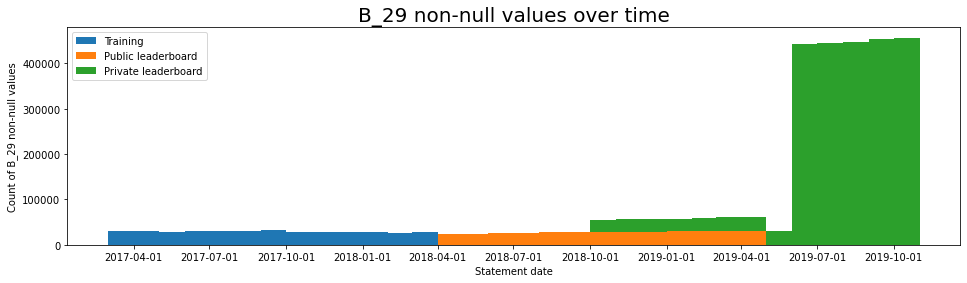

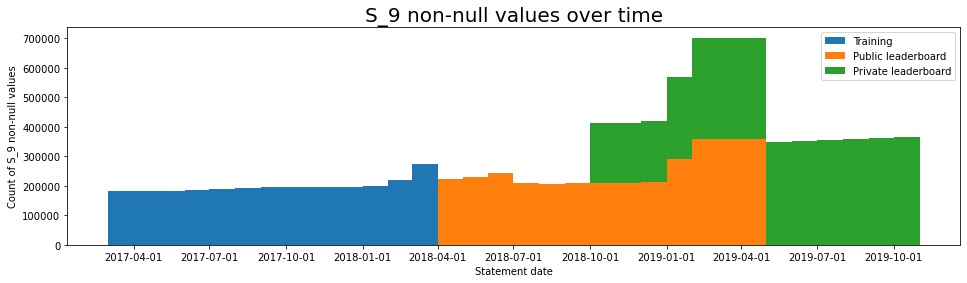

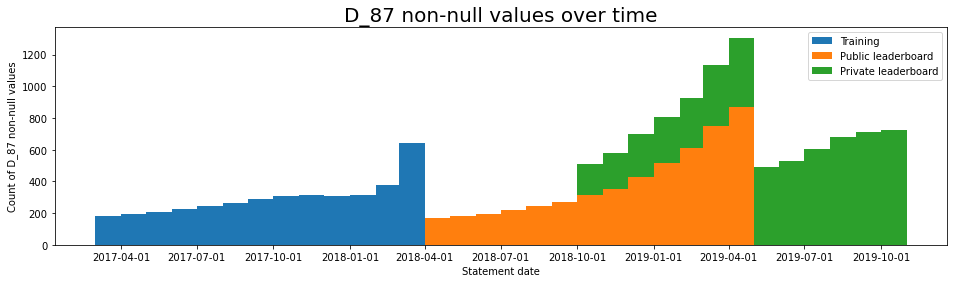

In [47]:
for f in [ 'B_29', 'S_9','D_87']:
    temp = pd.concat([train[[f, 'S_2']], test[[f, 'S_2']]], axis=0)
    temp['last_month'] = last_month
    temp['has_f'] = ~temp[f].isna() 

    plt.figure(figsize=(16, 4))
    plt.hist([temp.S_2[temp.has_f & (temp.last_month == 3)],   # ending 03/18 -> training
              temp.S_2[temp.has_f & (temp.last_month == 4)],   # ending 04/19 -> public lb
              temp.S_2[temp.has_f & (temp.last_month == 10)]], # ending 10/19 -> private lb
             bins=pd.date_range("2017-03-01", "2019-11-01", freq="MS"),
             label=['Training', 'Public leaderboard', 'Private leaderboard'],
             stacked=True)
    plt.xticks(pd.date_range("2017-03-01", "2019-11-01", freq="QS"))
    plt.xlabel('Statement date')
    plt.ylabel(f'Count of {f} non-null values')
    plt.title(f'{f} non-null values over time', fontsize=20)
    plt.legend()
    plt.show()

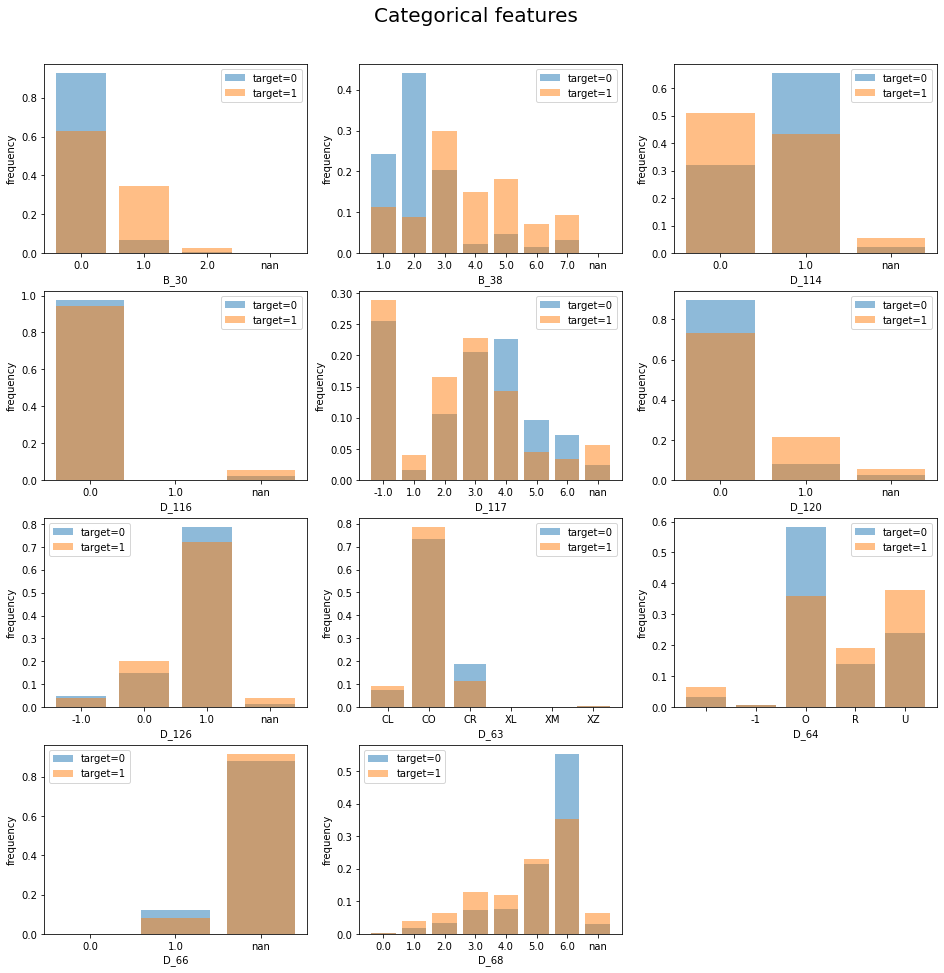

In [48]:
# The categorical features - histograms for target = 0,1
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
plt.figure(figsize=(16, 16))
for i, f in enumerate(cat_features): # 0, 1, ... B_30, B_38, D_114, ...
    plt.subplot(4, 3, i+1)
    temp = pd.DataFrame(train[f][train.target == 0].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=0')
    temp = pd.DataFrame(train[f][train.target == 1].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=1')
    plt.xlabel(f)
    plt.ylabel('frequency')
    plt.legend()
    plt.xticks(temp.index, temp.value)
plt.suptitle('Categorical features', fontsize=20, y=0.93)
plt.show()
del temp

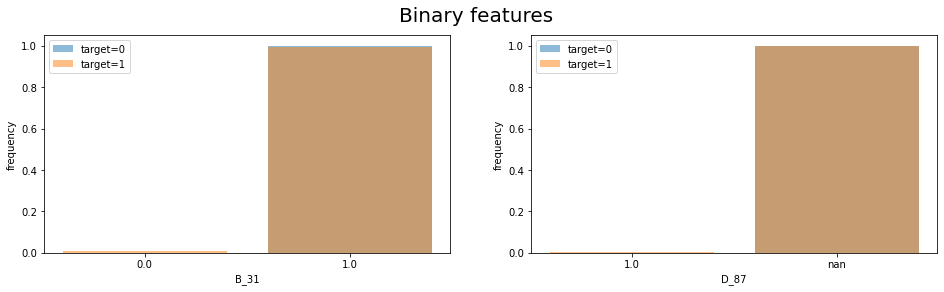

In [49]:
# The binary features
bin_features = ['B_31', 'D_87']
plt.figure(figsize=(16, 4))
for i, f in enumerate(bin_features):
    plt.subplot(1, 2, i+1)
    temp = pd.DataFrame(train[f][train.target == 0].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=0')
    temp = pd.DataFrame(train[f][train.target == 1].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=1')
    plt.xlabel(f)
    plt.ylabel('frequency')
    plt.legend()
    plt.xticks(temp.index, temp.value)
plt.suptitle('Binary features', fontsize=20)
plt.show()
del temp

175


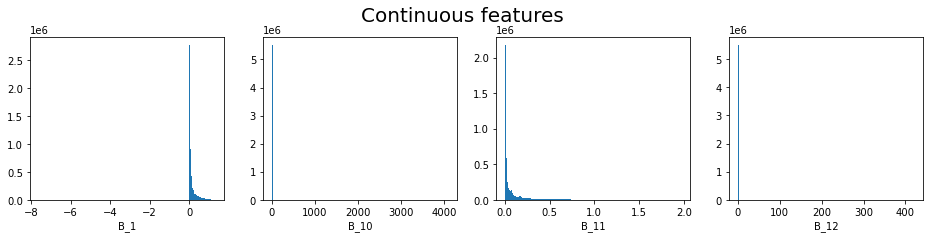

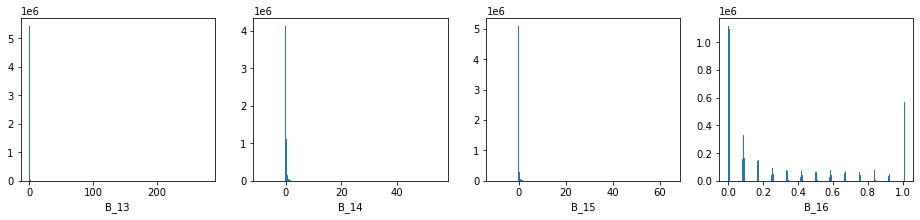

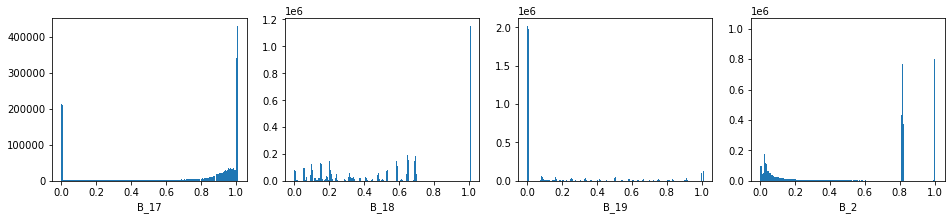

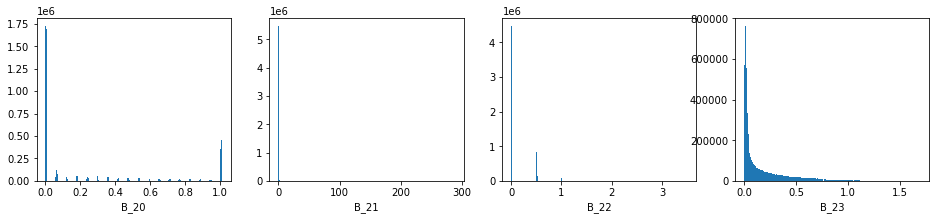

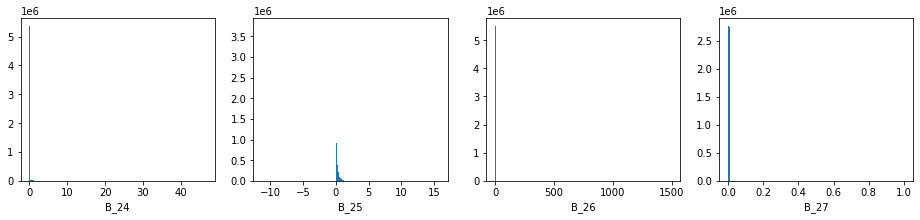

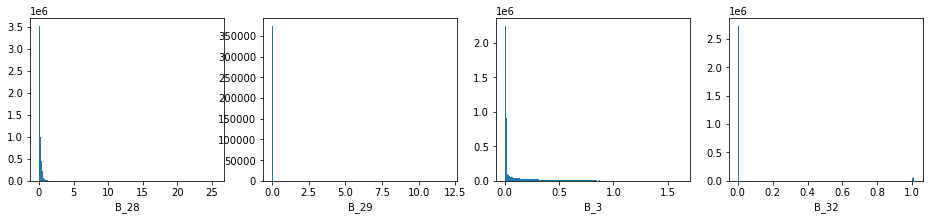

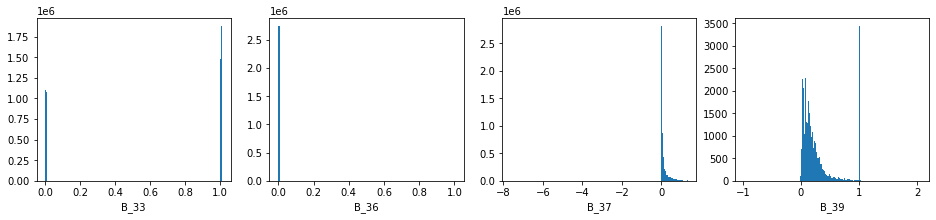

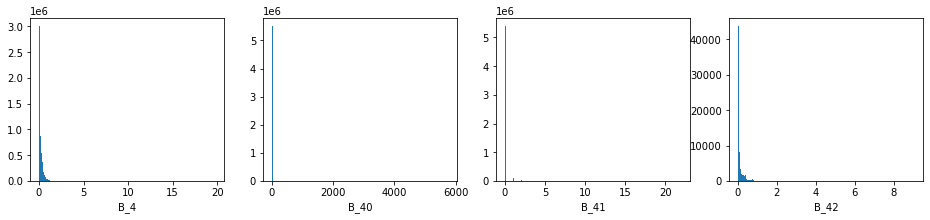

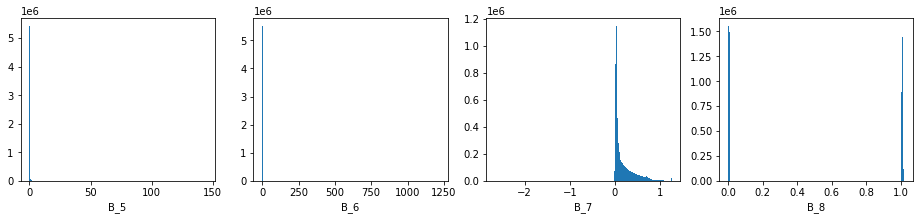

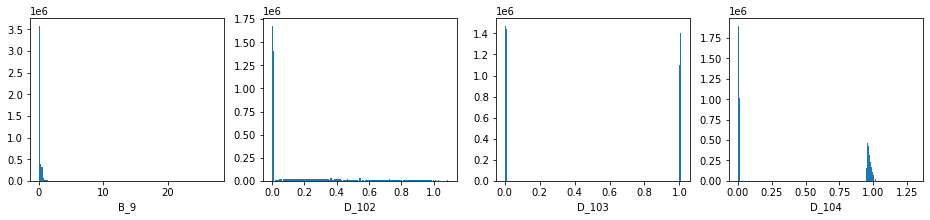

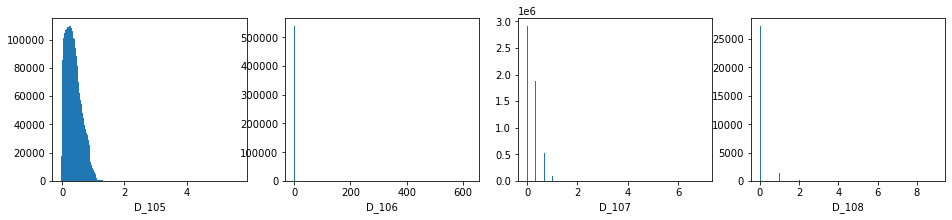

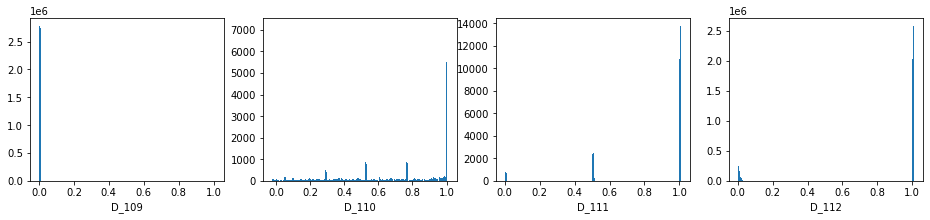

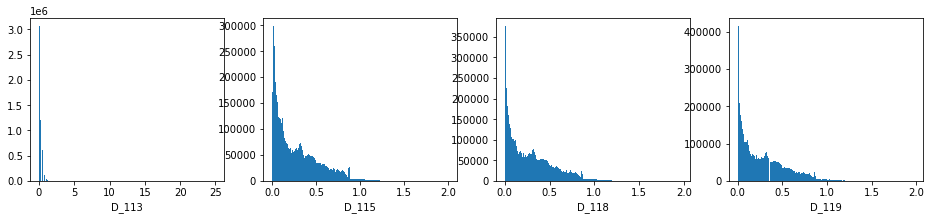

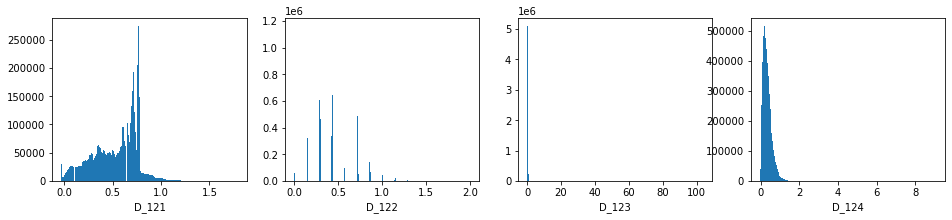

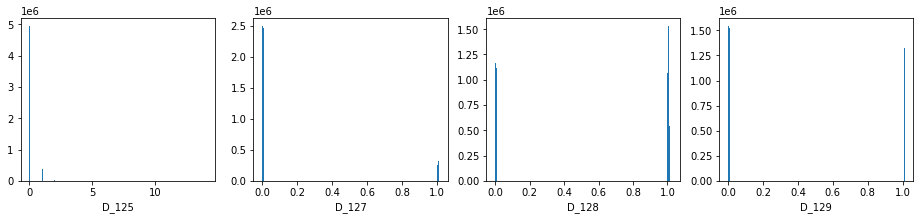

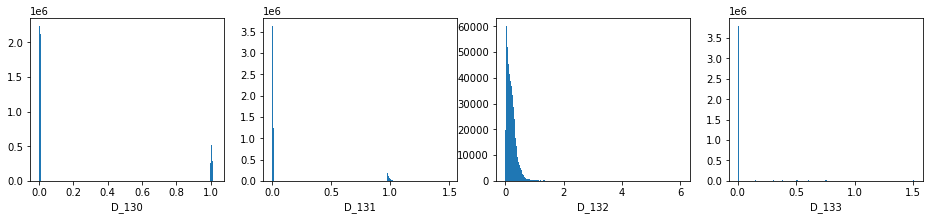

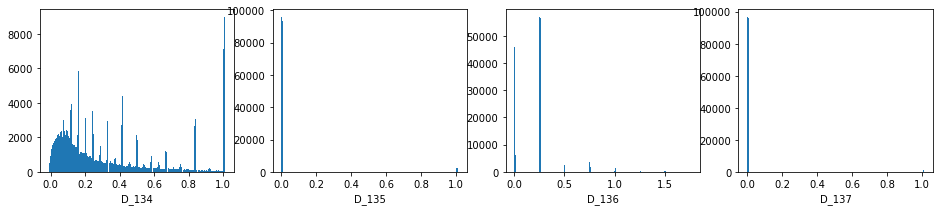

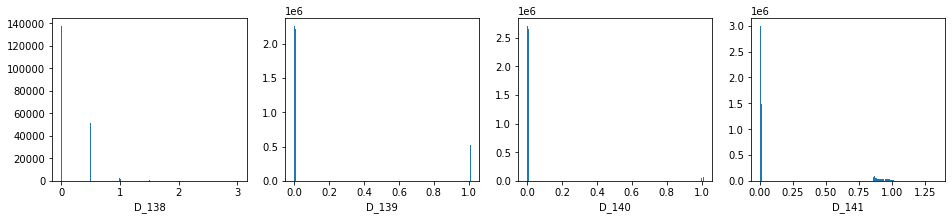

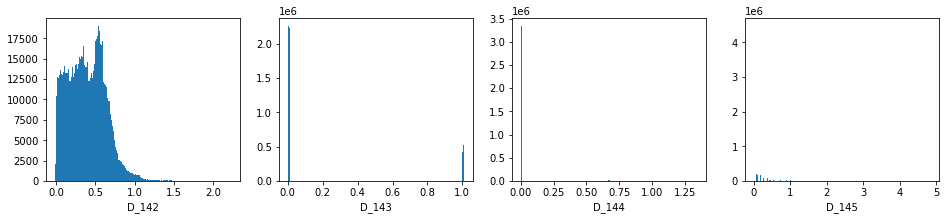

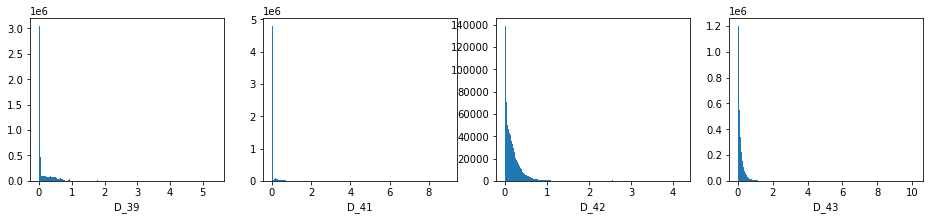

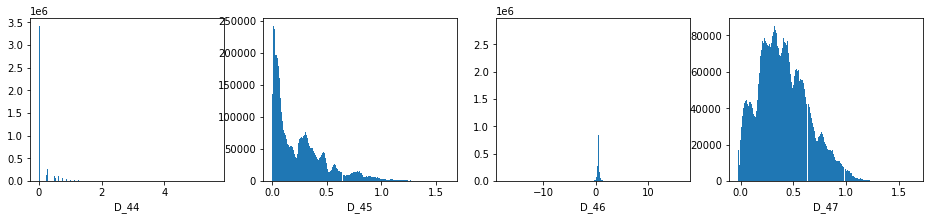

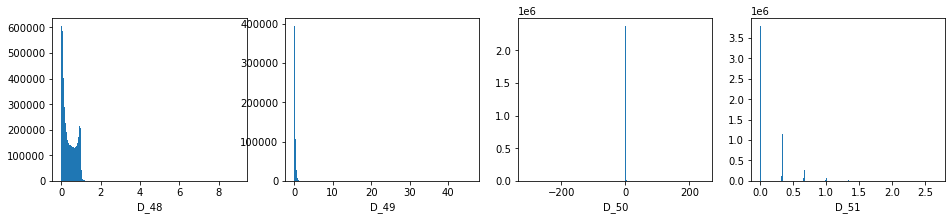

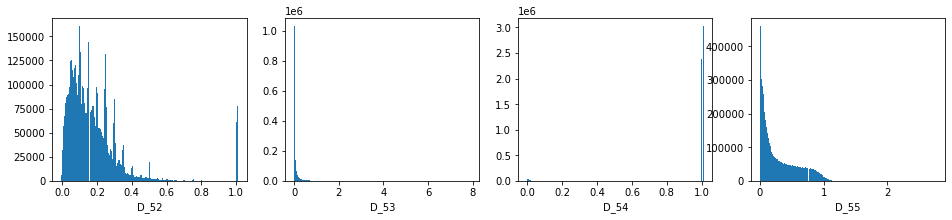

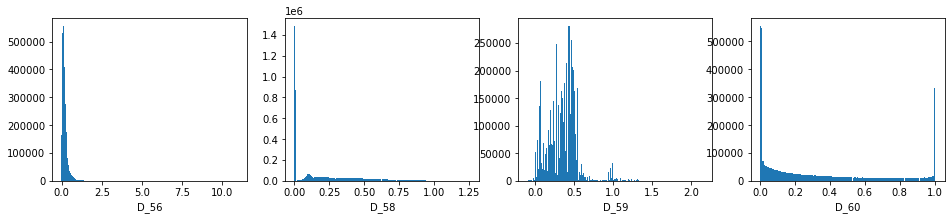

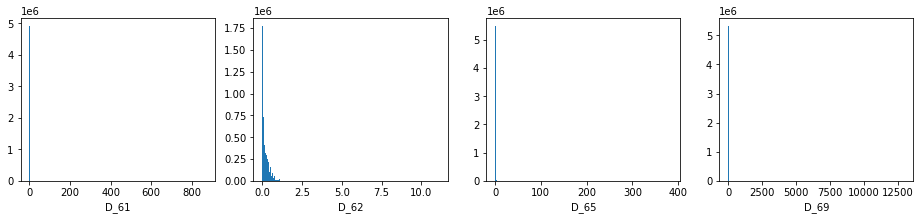

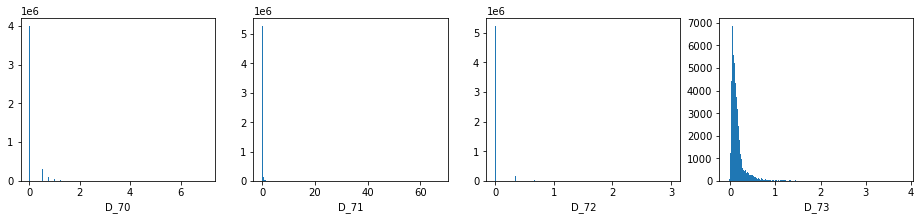

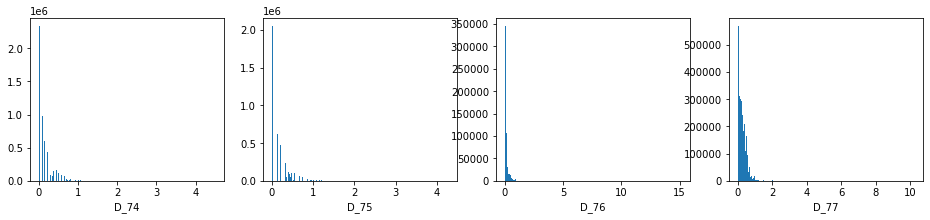

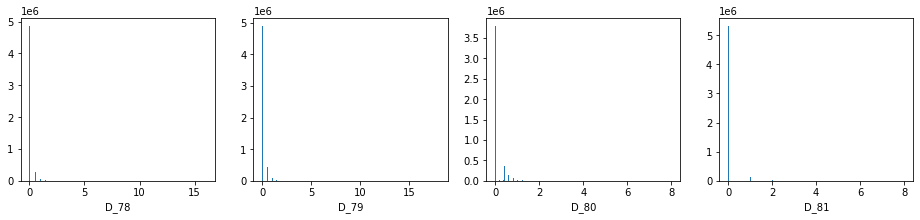

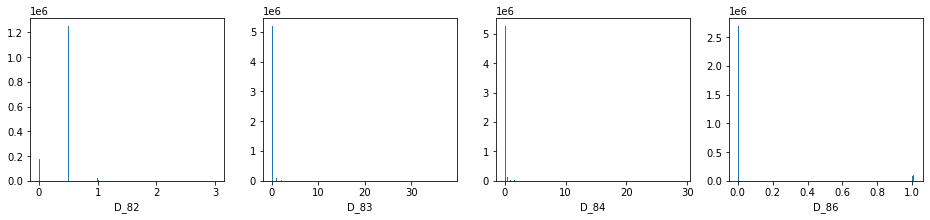

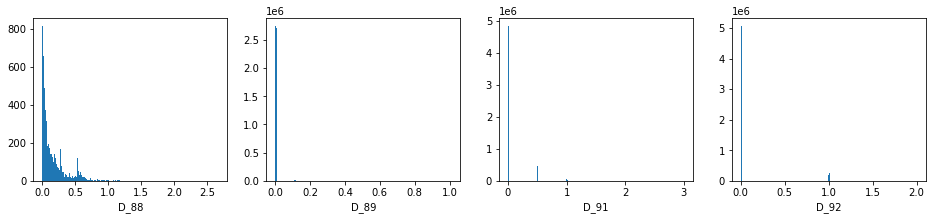

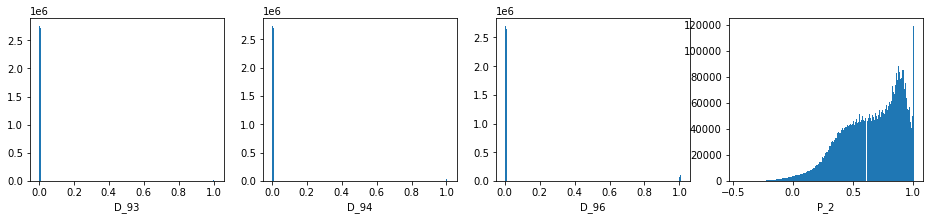

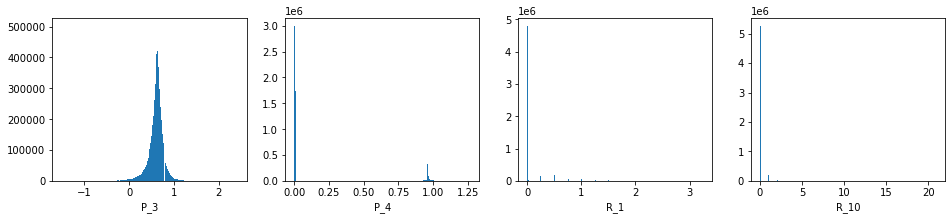

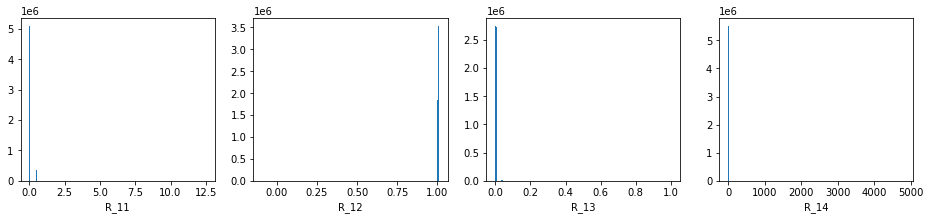

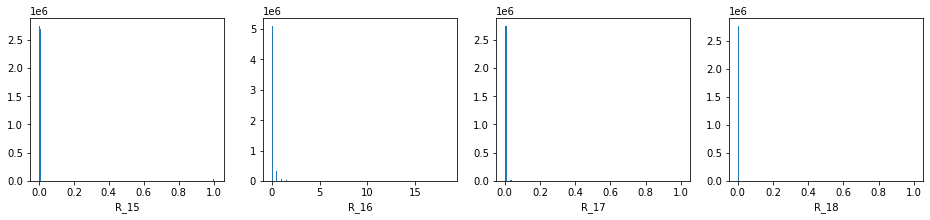

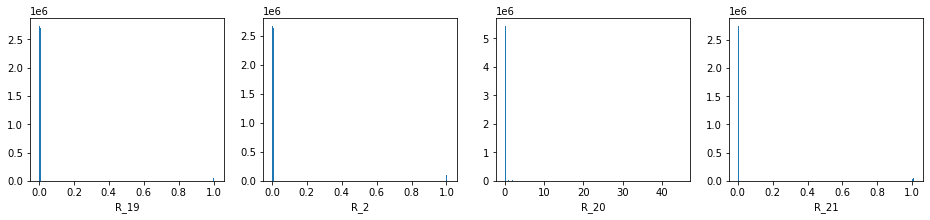

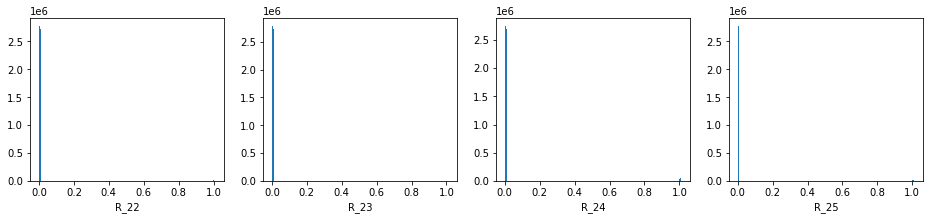

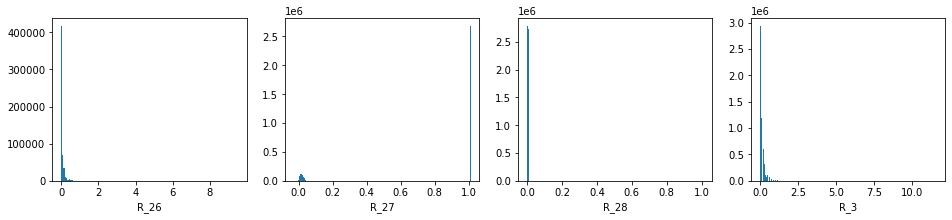

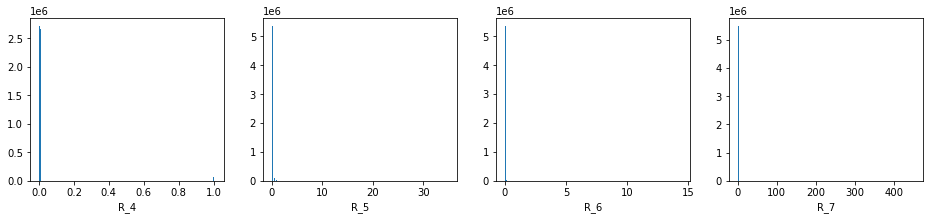

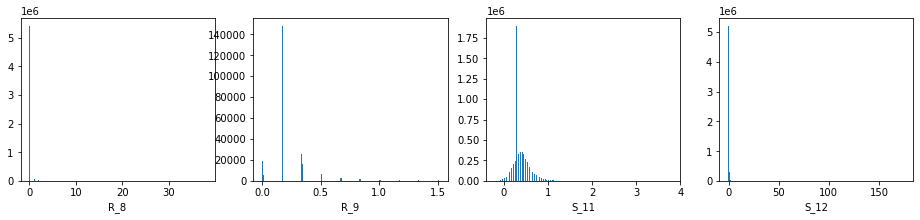

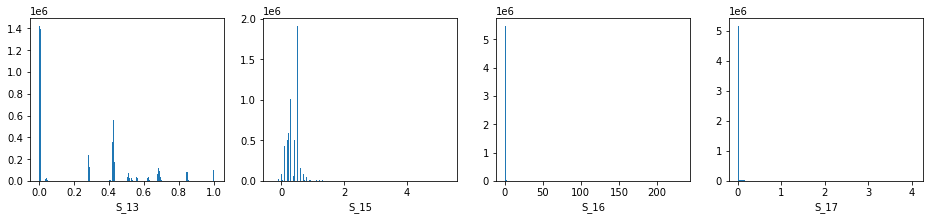

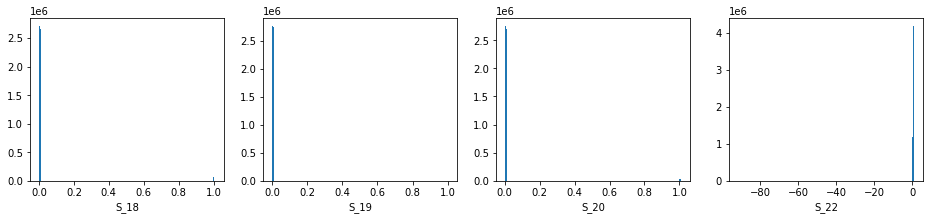

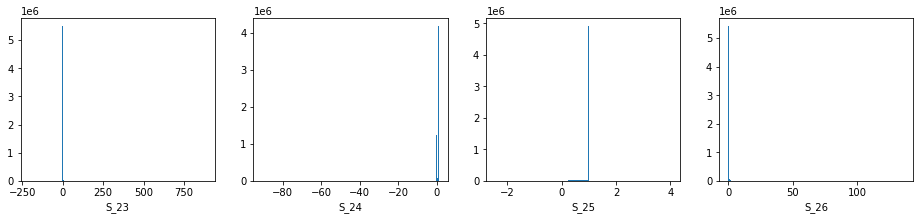

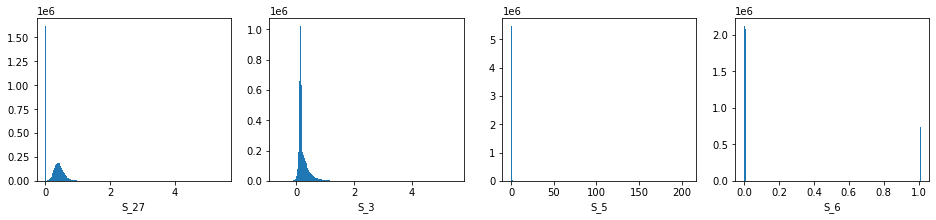

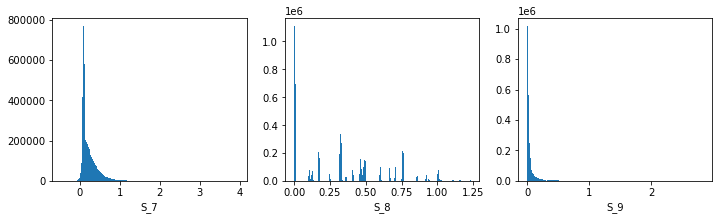

In [50]:
# The numerical features - without categorical, binary, id, target and S_2
cont_features = sorted([f for f in train.columns if f not in cat_features + bin_features + ['customer_ID', 'target', 'S_2']])
print(len(cont_features))
# print(cont_features)
ncols = 4
for i, f in enumerate(cont_features):
    if i % ncols == 0: 
        if i > 0: plt.show()
        plt.figure(figsize=(16, 3))
        if i == 0: plt.suptitle('Continuous features', fontsize=20, y=1.02)
    plt.subplot(1, ncols, i % ncols + 1)
    plt.hist(train[f], bins=200)
    plt.xlabel(f)
plt.show()